In [1]:
%matplotlib inline

import gc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**H2** Return to the `Trolley` data. Define and fit a varying intercepts model for these data. Cluster intercepts on individual participants, as indicated by the unique values in the `id` variable. Include action, intention, and contact as ordinary terms. Compare the varying intercepts model and a model that ignores individuals, using both WAIC and posterior predictions. What is the impact of individual variation in these data?

In [3]:
data = pd.read_csv('../data/Trolley.csv', sep=';')
indiv = (data['id'].drop_duplicates().reset_index(drop=True).reset_index()
         .set_index('id')['index'].rename('person_i').to_frame())
data = pd.merge(data, indiv, left_on='id', right_index=True)

data.sample(5)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,person_i
934,cibur,4,29,96;586,57,0,High School Graduate,0,1,1,bur,1,31
4547,flswi,6,6,97;336,40,1,Master's Degree,0,0,0,swi,0,151
4650,cfaqu,3,20,97;356,48,1,Master's Degree,0,0,1,aqu,1,155
4874,flcar,2,18,97;408,46,0,Graduate Degree,0,0,0,car,0,162
1052,cfrub,5,7,96;603,23,1,Bachelor's Degree,0,0,1,rub,1,35


In [60]:
with pm.Model() as m_no_intercept:
    num_persons = data.person_i.nunique()
    
    cutpoints = pm.Normal(
        'cutpoints', mu=0, sd=1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.linspace(-3, 3, 6))

    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)

    phi = (
        beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m_no_intercept.name = 'no intercept'
    m_no_intercept.trace = pm.sample(
        3000, tune=1000, chains=2,
    )


/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, cutpoints]
Sampling 2 chains: 100%|██████████| 8000/8000 [05:08<00:00, 19.54draws/s]


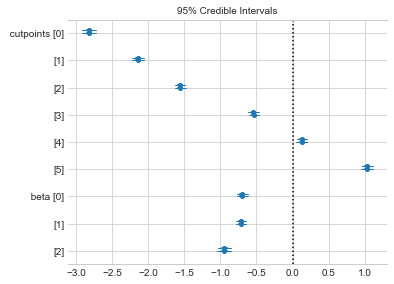

In [61]:
pm.forestplot(m_no_intercept.trace, varnames=['cutpoints', 'beta'], rhat=False)
None

In [62]:
del prev_cutpoints

In [63]:
with pm.Model() as m_no_pooling:
    num_persons = data.person_i.nunique()

    cutpoints = pm.Normal(
        'cutpoints',
        mu=0,
        sd=1.5,
        transform=pm.distributions.transforms.ordered,
        testval=np.linspace(-3, 3, 6),
        shape=6
    )

    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)
    alpha = pm.Normal('alpha', mu=0, sd=2,
                      shape=num_persons)

    phi = (
        alpha[data.person_i.values]
        + beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )    

    m_no_pooling.name = 'no pooling'
    m_no_pooling.trace = pm.sample(
        3000, tune=1000, chains=2,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, cutpoints]
Sampling 2 chains: 100%|██████████| 8000/8000 [14:58<00:00,  8.90draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


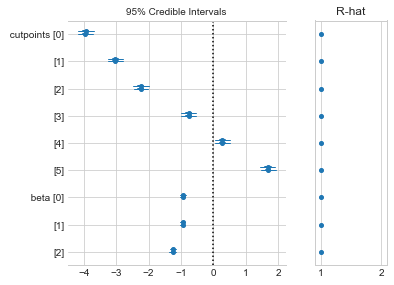

In [64]:
pm.forestplot(m_no_pooling.trace, varnames=['cutpoints', 'beta'],)
None

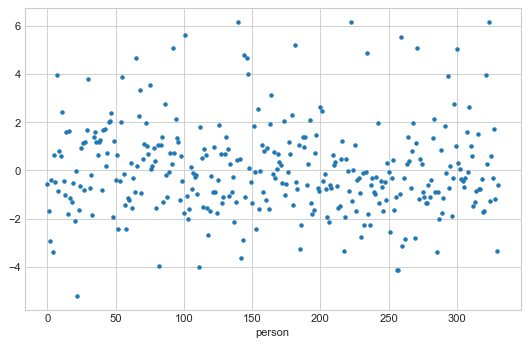

In [65]:
tmp = pd.Series(m_no_pooling.trace['alpha'].mean(axis=0))

fig = plt.figure(figsize=(8, 5), dpi=80)
plt.scatter(tmp.index, tmp, marker='.')
plt.gca().set(xlabel='person')
None

In [53]:
with pm.Model() as m_hier:
    num_persons = data.person_i.nunique()
    
    cutpoints = pm.Normal(
        'cutpoints',
        mu=0,
        sd=1.5,
        transform=pm.distributions.transforms.ordered,
        testval=np.linspace(-3, 3, 6),
        shape=6
    )

    alpha_sd_bar = pm.Exponential('alpha_sd_bar', lam=1)
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)

    alpha = pm.Normal('alpha', mu=0, sd=alpha_sd_bar,
                      shape=num_persons)

    phi = (
        alpha[data.person_i.values]
        + beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )    

    m_hier.name = 'hierarchical'
    m_hier.trace = pm.sample(
        3000, tune=1000, chains=2,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, alpha_sd_bar, cutpoints]
Sampling 2 chains: 100%|██████████| 8000/8000 [09:27<00:00, 11.04draws/s] 
The acceptance probability does not match the target. It is 0.6961192167464709, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


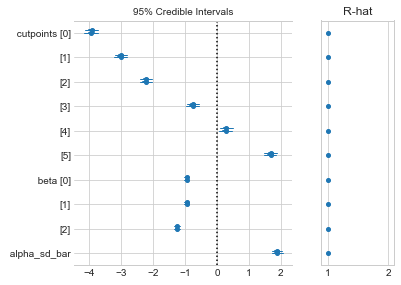

In [54]:
pm.forestplot(m_hier.trace, varnames=['cutpoints', 'beta', 'alpha_sd_bar'])
None

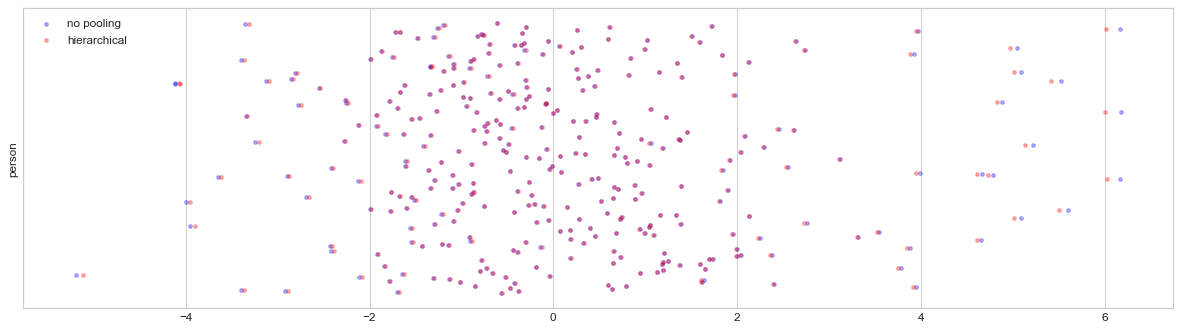

In [76]:
tmp1 = pd.Series(m_no_pooling.trace['alpha'].mean(axis=0))
tmp2 = pd.Series(m_hier.trace['alpha'].mean(axis=0))

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 4), dpi=85)

ax1.scatter(tmp1, tmp1.index,
            marker='.', label='no pooling', c='b', alpha=.3)
ax1.scatter(tmp2, tmp2.index,
            marker='.', label='hierarchical', c='r', alpha=.3)
ax1.set(ylabel='person', yticks=[])
ax1.legend()

fig.tight_layout()
None

In [77]:
pm.compare({
    m_no_intercept: m_no_intercept.trace,
    m_no_pooling: m_no_pooling.trace,
    m_hier: m_hier.trace,
})

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
no pooling,31338.2,356.59,0,0.91,178.54,0,1
hierarchical,31339,353.59,0.84,0,177.27,1.69,1
no intercept,37089.9,8.98,5751.78,0.09,75.79,173.41,0


---
**H3** The `Trolley` data are also clustered by story, which indicates a unique narrative for each
vignette. Define and fit a cross-classified varying intercepts model with both `id` and `story`. Use the
same ordinary terms as in the previous problem. Compare this model to the previous models. What
do you infer about the impact of different stories on responses?


In [28]:
stories = (data.story.drop_duplicates().reset_index(drop=True).reset_index()
           .set_index('story')['index'].rename('story_i').to_frame())

data = pd.merge(data, stories, left_on='story', right_index=True)

data.sample(5)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,person_i,story_i
2768,fkbox,7,10,96;915,56,1,Some College,1,0,0,box,1,92,3
8451,ikshi,3,17,97;880,19,0,Some College,1,1,0,shi,1,281,11
9057,ilshi,2,26,97;980,22,0,Some College,0,1,0,shi,0,301,11
6,fkaqu,5,29,96;434,14,0,Middle School,1,0,0,aqu,1,0,0
4575,flche,6,4,97;349,23,0,Bachelor's Degree,0,0,0,che,0,152,8


In [78]:
with pm.Model() as m_hier_story:
    num_persons = data.person_i.nunique()
    num_stories = data.story_i.nunique()
    
    cutpoints = pm.Normal(
        'cutpoints',
        mu=0,
        sd=1.5,
        transform=pm.distributions.transforms.ordered,
        testval=np.linspace(-3, 3, 6),
        shape=6
    )

    person_sd_bar = pm.Exponential('person_sd_bar', lam=1)
    story_sd_bar = pm.Exponential('story_sd_bar', lam=1)
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)

    person = pm.Normal('person', mu=0, sd=person_sd_bar,
                      shape=num_persons)
    story = pm.Normal('story', mu=0, sd=story_sd_bar,
                      shape=num_persons)

    phi = (
        person[data.person_i.values]
        + story[data.story_i.values]
        + beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m_hier_story.name = 'hierarchical, story'
    m_hier_story.trace = pm.sample(
        3000, tune=1500, chains=2,
    )

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '9933' (I am process '6307')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/petrushev/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted a

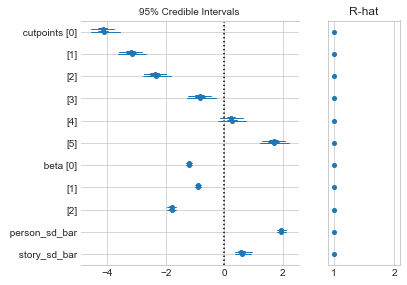

In [79]:
pm.forestplot(m_hier_story.trace,
              varnames=['cutpoints', 'beta', 'person_sd_bar', 'story_sd_bar'])
None

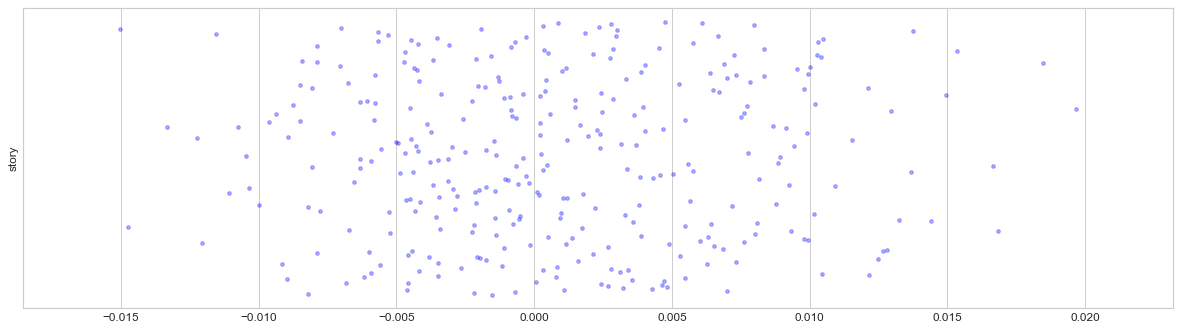

In [82]:
tmp = pd.Series(m_hier_story.trace['story'].mean(axis=0))

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 4), dpi=85)

ax1.scatter(tmp.iloc[15:], tmp.iloc[15:].index,
            marker='.', c='b', alpha=.3)
ax1.set(ylabel='story', yticks=[])

fig.tight_layout()
None

In [83]:
with pm.Model() as m_hier_story_only:
    num_stories = data.story_i.nunique()
    
    cutpoints = pm.Normal(
        'cutpoints',
        mu=0,
        sd=1.5,
        transform=pm.distributions.transforms.ordered,
        testval=np.linspace(-3, 3, 6),
        shape=6
    )

    story_sd_bar = pm.Exponential('story_sd_bar', lam=1)
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=3)

    story = pm.Normal('story', mu=0, sd=story_sd_bar,
                      shape=num_persons)

    phi = (
        story[data.story_i.values]
        + beta[0] * data.action.values
        + beta[1] * data.intention.values
        + beta[2] * data.contact.values
    )

    responses = pm.OrderedLogistic(
        'responses', phi, cutpoints,
        observed=data.response - 1
    )

    m_hier_story_only.name = 'hierarchical, story only'
    m_hier_story_only.trace = pm.sample(
        3000, tune=1500, chains=2,
    )

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [story, beta, story_sd_bar, cutpoints]
Sampling 2 chains: 100%|██████████| 9000/9000 [23:01<00:00,  9.14draws/s]  
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


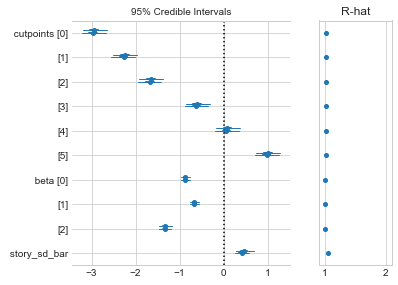

In [84]:
pm.forestplot(m_hier_story_only.trace,
              varnames=['cutpoints', 'beta', 'story_sd_bar'])
None

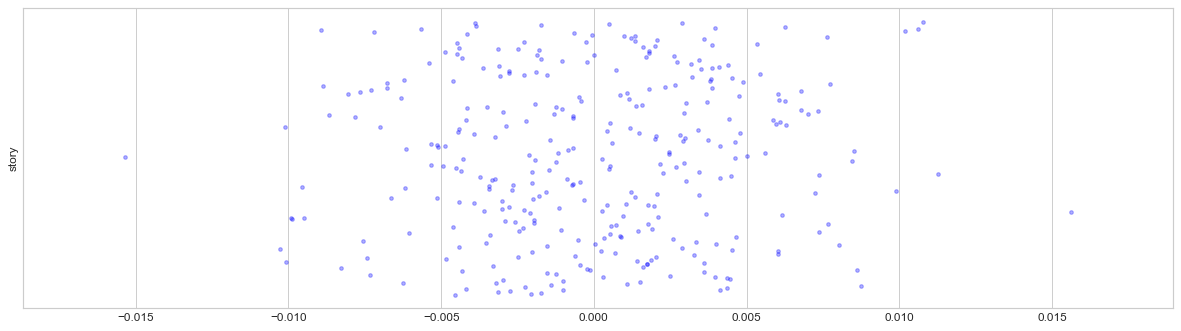

In [85]:
tmp = pd.Series(m_hier_story_only.trace['story'].mean(axis=0))

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 4), dpi=85)
ax1.scatter(tmp.iloc[15:], tmp.iloc[15:].index,
            marker='.', c='b', alpha=.3)
ax1.set(ylabel='story', yticks=[])
fig.tight_layout()
None

In [86]:
pm.compare({
    m_no_intercept: m_no_intercept.trace,
    m_no_pooling: m_no_pooling.trace,
    m_hier: m_hier.trace,
    m_hier_story: m_hier_story.trace,
    m_hier_story_only: m_hier_story_only.trace,
})

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
"hierarchical, story",30689.3,363.73,0,0.91,179.06,0,1
no pooling,31338.2,356.59,648.81,0,178.54,48.08,1
hierarchical,31339,353.59,649.65,0,177.27,47.95,1
"hierarchical, story only",36726.2,19.88,6036.81,0.09,82.94,174.73,0
no intercept,37089.9,8.98,6400.59,0,75.79,174.55,0
